# Reverse Engineering the UR3e IK parameters

Universal Robots posts the [DH parameters](https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/) of all of their robots online, the hope is with these parameters for our robot, and the joint position read off the modbus, we might be able to reverse-engineering the inverse kinematics and write our own controller for working with a floating coordinate system.

In [ ]:
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%load_ext autoreload
%autoreload 2
%matplotlib inline


np.set_printoptions(formatter={'float': '{: 0.4f}'.format})


In [ ]:
DH = np.array([[0, 0, 0.1519,np.pi/2],
                    [0,-0.2434,0.,0.],
                    [0,-0.2132,0.,0.],
                    [0,0.,0.1311,np.pi/2],
                    [0,0.,0.0854,-np.pi/2],
                    [0,0.,0.0921,0.]])

print("Available files:")
files = []
for file in os.listdir():
    if file.endswith(".json"):
        # print("\t" + file)
        files.append(file)

i = 8

path = os.path.abspath("..\\IK_Scans") + "\\" + files[i]

print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

if 'Notes' in json_data.keys():
    print(json_data['Notes'])

joints_at_points = json_data["joints_at_points"]

start_joints = joints_at_points[0][1]

print(np.rad2deg(start_joints))
names = ("Floating coordinate system", "Joint angles", "Base position")
for i in range(3):
    print(f"{names[i]}: {joints_at_points[0][i]}")
print(f"Number of points: {len(joints_at_points)}")

In [ ]:
links = np.zeros((6,4,4))
print(links[0])

In [206]:
#               theta,a,d,alpha     (radians and meters)
# Theta represents the current orientation of that particular joint
tcp_offset = 0.173 # Accurate to the programmed TCP offset
DH = np.array([[0, 0, 0.15185,np.pi/2],
                [0,-0.24335,0.,0.],
                [0,-0.2132,0.,0.],
                [0,0.,0.13105,np.pi/2],
                [0,0.,0.08535,-np.pi/2],
                [0,0.,0.0921,0.],
                [0,0,tcp_offset,0]])

def plot_linkages(points, target=None):
    '''Accepts as input an (n,6) ndarray representing a series of n joint
    positions, with each (6,) subarray being in the form (X,Y,Z,beta,alpha,gamma)'''
    if len(points.shape) == 1:
        points = np.array([points])

    xlim,ylim,zlim = ([-0.5,0.5],[-0.5,0.5],[-0.5,0.5])
    
    points = np.append(np.array([[0,0,0,0,0,0]]),points,axis=0)
    
    fig = plt.figure(figsize=(24,6))
    ax = fig.add_subplot(1,4,1,projection='3d')
    
    # ax.quiver(Xs,points[:,1],points[:,2],points[:,3],points[:,4],points[:,5], c='r')
    Xs,Ys,Zs = points[:,0],points[:,1],points[:,2]
    ax.plot3D(Xs,Ys,Zs, c='r')
    ax.scatter(Xs,Ys,Zs,alpha=1,c=range(points.shape[0]),
        cmap='viridis', s=100)
    ax.set_title("3D view")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    ax = fig.add_subplot(1,4,2)
    ax.plot(Xs,Ys,c='r')
    ax.scatter(Xs,Ys,alpha=1,c=range(points.shape[0]),
        cmap='viridis', s=100)
    ax.set_title("Top view")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax = fig.add_subplot(1,4,3)
    ax.plot(Ys,Zs,c='r')
    ax.scatter(Ys,Zs,alpha=1,c=range(points.shape[0]),
        cmap='viridis', s=100)
    ax.set_title("Front view")
    ax.set_xlim(ylim)
    ax.set_ylim(zlim)

    ax = fig.add_subplot(1,4,4)
    ax.plot(Xs,Zs,c='r')
    ax.scatter(Xs,Zs,alpha=1,c=range(points.shape[0]),
        cmap='viridis', s=100)
    ax.set_title("Side view")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    plt.show()

def matrix_to_coordinates(mat):
    '''Accepts as input a 4x4 numpy array representing a transformation matrix
    and returns that transformation in an np array of the form
    [X,Y,Z, beta, alpha, gamma]'''
    X = mat[0,3]
    Y = mat[1,3]
    Z = mat[2,3]

    beta = np.arctan2((mat[0,0]**2 + mat[1,0]**2)**0.5,-mat[2,0])
    cosb=np.cos(beta)
    alpha = np.arctan2(mat[0,0]/cosb, mat[1,0]/cosb)
    gamma = np.arctan2(mat[2,2]/cosb, mat[2,1]/cosb)
    return np.array([X,Y,Z,beta,alpha,gamma])

def joints_forward_kinematics_messy(joints,plot=False):
    '''Accepts as input a list of 6 joint positions in radians'''
    joints = np.array(joints).flatten()
    # joints = np.append(joints,0)
    DH_params = DH.copy()
    DH_params[:,0] = joints

    j_pos = []
    for i in range(6):
        theta,a,d,alpha = DH_params[i,:].tolist()
        
        trans_1 = np.eye(4)
        trans_1[2,3] = d

        rot_1 = np.array([[np.cos(theta), -np.sin(theta),0,0],
                        [np.sin(theta), np.cos(theta),0,0],
                        [0,0,1,0],
                        [0,0,0,1]])
        
        trans_2 = np.eye(4)
        trans_2[0,3] = a

        rot_2 = np.array([[1,0,0,0],
                        [0,np.cos(alpha), -np.sin(alpha),0],
                        [0,np.sin(alpha), np.cos(alpha),0],
                        [0,0,0,1]])
        j_pos.append(np.matmul(trans_1,
                        np.matmul(rot_1,
                        np.matmul(trans_2,rot_2))))
    
    links = np.zeros((6,6))
    t = j_pos[0]
    links[0] = matrix_to_coordinates(t)
    for i in range(5):
        t = np.matmul(t,j_pos[i+1])
        links[i+1] = matrix_to_coordinates(t)

    if plot:
        plot_linkages(links)

    return matrix_to_coordinates(t)

def joints_forward_kinematics(joints,plot=False,debug=False):
    '''Accepts as input a list of 6 joint positions in radians, returns
    the point of the endpoint of the tool, in theory.'''
    joints = np.array(joints).flatten()
    # joints = np.append(joints,0)
    DH_params = DH.copy()
    DH_params[0:6,0] = joints

    j_pos = []
    for i in range(7):
        cos_io = np.cos(DH_params[i,0])
        sin_io = np.sin(DH_params[i,0])
        cos_i3 = np.cos(DH_params[i,3])
        sin_i3 = np.sin(DH_params[i,3])

        j_pos.append(np.array([
            [cos_io, -sin_io * cos_i3, sin_io * sin_i3, DH_params[i,1] * cos_io],
            [sin_io, cos_io * cos_i3, -cos_io * sin_i3, DH_params[i,1] * sin_io],
            [0., sin_i3, cos_i3,DH_params[i,2]],
            [0.,0.,0.,1.]
            ]))
    
    # (T1,T2,T3,T4,T5,T6) = tuple(j_pos)
    # t = T1
    if debug:
        [print(f"{j}\n--------------") for j in tuple(j_pos)]

    links = np.zeros((7,6))
    t = j_pos[0]
    if debug:
        print(t)
    links[0] = matrix_to_coordinates(t)
    for i in range(6):
        t = np.matmul(t,j_pos[i+1])
        if debug:
            print(t)
        links[i+1] = matrix_to_coordinates(t)

    if plot:
        plot_linkages(links)

    return matrix_to_coordinates(t)


Theoretical joint angles: [0 0 0 0 0 0]


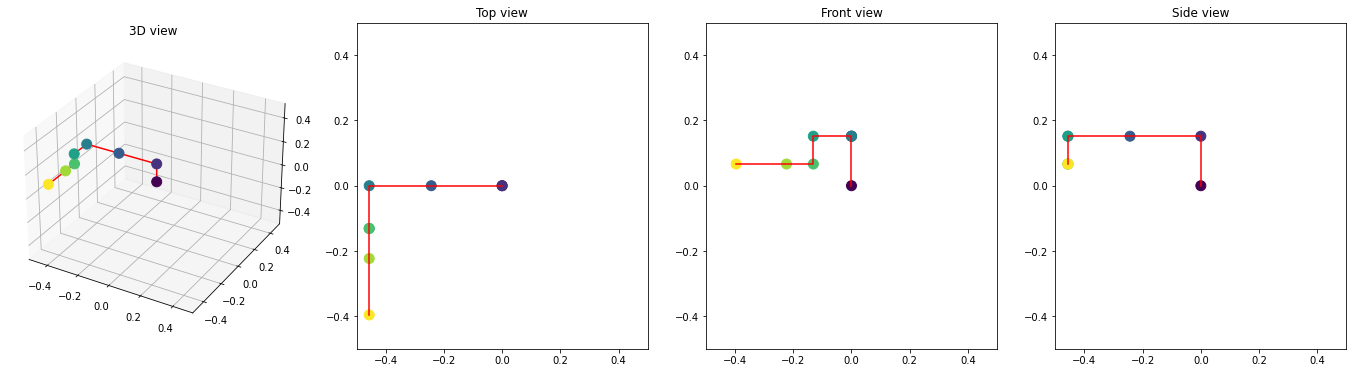

Endpoint: [-0.4566 -0.3962  0.0665  1.5708  1.5708  0.0000]


In [207]:
# test_joints = np.array([0,-np.pi/4,0,-np.pi/4,0,0])
test_joints = np.array([0,0,0,0,0,0])
# offset = np.array([0,-np.pi/4,0,np.pi/4,0.,0])
offset = np.array([0,0,0,0,0,0])
print(f"Theoretical joint angles: {test_joints+offset}")
fin = joints_forward_kinematics(test_joints + offset,plot=True,debug=False)
print(f"Endpoint: {fin}")

In [ ]:
index = 0
stepwise = True

joints = joints_at_points[index][1]
base_pos = joints_at_points[index][2]
base_pos = np.array(base_pos).flatten()
floating_pos = joints_at_points[index][0]

# ("Floating coordinate system", "Joint angles", "Base position")

# print(np.array(start_joints).flatten())
calc = joints_forward_kinematics(joints)

# error = []
start_position = joints_forward_kinematics(joints_at_points[0][1])
l = 32
errors = np.zeros((l+1,6))

for i in range(l):
    joints = joints_at_points[i][1]
    base_pos = joints_at_points[i][2]
    base_pos = np.array(base_pos).flatten()
    floating_pos = np.array(joints_at_points[i][0]).flatten() * 0.001

    # ("Floating coordinate system", "Joint angles", "Base position")
    actual_joints = np.array(joints).flatten()

    calc = joints_forward_kinematics(joints)
    # print(calc)
    # print(base_pos)
    if stepwise:
        print(f"Starting position:\t\t{start_position}")
        print(f"Current position:\t\t{base_pos}")
        print(f"Current joint angles:\t\t{actual_joints}")
        print(f"Calculated current position:\t{calc}")
        print(f"Error:\t\t\t\t{calc - base_pos}")
        print(f"Normalized translational change, actual: {np.sum((base_pos-start_position)[0:3]**2)**0.5}")
        print(f"Normalized translational change, calculated: {np.sum((calc-start_position)[0:3]**2)**0.5}")
        print(f"Motion in floating coordinate system: {floating_pos}")
        print(f"Normalized translational change, floating: {np.sum(floating_pos[0:3]**2)**0.5}")
        print("---------------------")
    errors[i] = np.abs(calc-base_pos)
    # print(f"Non-dimensional error {np.sum((calc-base_pos)[0:3]**2)**0.5}")

print(f"Average error: {np.average(errors,axis=0)}")
# print(errors)


In [ ]:
print(DH)
theta,d,a,alpha = DH[2,:].tolist()
print(d)

In [ ]:
(x0,x1) = (0,0)
(y0,y1) = (0,0)
(z0,z1) = (-9,9)
(Rx0,Rx1) = (-14,14)
(Ry0,Ry1) = (-14,14)
(Rz0,Rz1) = (0,0)

res=(1,2)

X,Y,Z,Rx,Ry,Rz = np.mgrid[
            x0:x1:(int((x1-x0)/res[0])+1)*1j,
            y0:y1:(int((y1-y0)/res[0])+1)*1j,
            z0:z1:(int((z1-z0)/res[0])+1)*1j,
            Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
            Ry0:Ry1:(int((Ry1-x0)/res[1])+1)*1j,
            Rz0:Rz1:(int((Rz1-x0)/res[1])+1)*1j]
all_points = np.vstack((X.flatten(),Y.flatten(),Z.flatten(),
        Rx.flatten(),Ry.flatten(),Rz.flatten())).T

print(all_points[0:5])

In [ ]:
links = np.eye(6)
print(links)
print(links[:,1])